In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import skfuzzy as fuzz
from scipy.interpolate import griddata

# Memership function generators

In [2]:
# function to produce prob of a gaussian
def gaussian(X, mu, sigma):
    '''Get pdf over X'''
    return np.exp(-((X - mu) ** 2.) / float(sigma) ** 2.)

def trapezoid(X, a, b, c, d):
    """
    Generate a trapezoid function.

    Parameters:
    X (numpy.ndarray): Input values.
    a (float): Left start of the trapezoid.
    b (float): Left end of the flat top.
    c (float): Right end of the flat top
    d (float): Right end of the trapezoid.

    Returns:
    numpy.ndarray: Trapezoid function values.
    """
    return np.where((X < a) | (X > d), 0.0,
                    np.where((X >= a) & (X < b), (X - a) / (b - a),
                             np.where((X >= b) & (X <= c), 1.0,
                                      np.where((X > c) & (X <= d), (d - X) / (d - c), 0.0))))

def trimf(x, a, b, c):
    assert a<=b<=c<=x[-1], "Vertices need to be positioned properly"

    y = np.zeros_like(x)

    # left side
    if a!=b:
        left_slope = 1/(b-a)
        idx = np.nonzero(np.logical_and(a<=x, x<=b))

        y[idx] = left_slope*(x[idx] - a)
    
    else:
        idx = np.nonzero(x==a)
        y[idx] = 1

    # right side
    if b!=c:
        right_slope = -1/(c-b)

        idx = np.nonzero(np.logical_and(b<=x, x<=c))
        y[idx] = right_slope*(x[idx] - b) + 1
    
    else:
        idx = np.nonzero(x==c)
        y[idx] = 1
    
    return y
    

# Operators

In [3]:
def implication_zadeh(x,y,z=None):
    result = min( 1.0 , 1.0 - x + y )
    return result            

def implication_correlation_min(x,y,z=None):
    if z!= None:
        return min( x, y, z )
        
    else:
        return min ( x, y )

def implication_correlation_prod(x,y,z=None):
    if z != None:
        return (x * y * z)
    else:
        return (x * y)

def cylindrical_closure(A1,A2,A3=None):
    if A3 is not None:
        D = np.zeros((len(A3),len(A2),len(A1)))

        for k in range(len(A3)):
            for j in range(len(A2)):
                for i in range(len(A1)):
                    D[k,j,i] = min( A1[i], A2[j], A3[k] )
        
    else:
        D = np.zeros( (len(A1), len(A2)) )
        for i in range(len(A1)):
            for j in range(len(A2)):
                D[i,j] = min( A1[i], A2[j] )

    return D

def relation(D,Y,implication_op):
    R = []
    
    # for 3 antecedents
    if len(D.shape) == 3:

        for y in Y:
            r = np.zeros_like(D)
            
            for k in range(D.shape[0]):
                for j in range(D.shape[1]):
                    for i in range(D.shape[2]):
                        r[k,j,i] = implication_op(D[k,j,i],y)
            
            R.append(r)
    
    # for 2 antecedents
    else:
        for y in Y:
            r = np.zeros_like(D)
            
            for i in range(D.shape[0]):
                for j in range(D.shape[1]):
                    r[i,j] = implication_op(D[i,j],y)
            
            R.append(r)
    
    return np.asarray(R)




def COI(R,Y,A1_,A2_=None,A3_=None):

    # 3 antecedents
    if A3_ is not None:
        Y_ = np.zeros_like(Y)
        R_ = np.zeros_like(R)
        D_ = cylindrical_closure(A1_,A2_,A3_)

        for s in range(R.shape[0]):
            for k in range(R.shape[1]):
                for j in range(R.shape[2]):
                    for i in range(R.shape[3]):
                        R_[s,k,j,i] = min( R[s,k,j,i],D_[k,j,i] )

        for s in range(R_.shape[0]):
            Y_[s] = np.max(R_[s])
    
    # 2 antecedents
    else: 
        R_ = np.zeros_like(R)
        D_ = cylindrical_closure(A1_,A2_)
        Y_ = np.zeros_like(Y)

        for k in range(R.shape[0]):
            for j in range(R.shape[1]):
                for i in range(R.shape[2]):
                    R_[k,j,i] = min( R[k,j,i], D_[j,i])

        for k in range(R_.shape[0]):
            Y_[k] = np.max(R_[k])
    
        
    return Y_
        
def relation_1_ant(A,B,implication_op):
    R = np.zeros((len(A),len(B)))

    for i in range(len(A)):
        for j in range(len(B)):
            R[i,j] = implication_op(A[i],B[j])
    
    return R

def COI_1_ant(A_,B,R):
    B_ = np.zeros_like(B)

    for j in range(len(B)):
        for i in range(len(A_)):
            temp = min(A_[i],R[i,j])
            if(temp > B_[j]):
                B_[j] = temp
    
    return B_



# 1 antecedent example (Example 7.1)

In [4]:
A = [1,0.8,0,0] # antecedent
B = [0,0.5,1,0.5,0] # consequent

ops = [implication_correlation_min,implication_correlation_prod,implication_zadeh]

for op in ops:
    R = relation_1_ant(A,B,op)
    print("R:", R)

    A_ = [0.7,0.4,0,0]
    print("A':",A_)
    B_ = COI_1_ant(A_,B,R)
    print("B':",B_)

R: [[0.  0.5 1.  0.5 0. ]
 [0.  0.5 0.8 0.5 0. ]
 [0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0. ]]
A': [0.7, 0.4, 0, 0]
B': [0.  0.5 0.7 0.5 0. ]
R: [[0.  0.5 1.  0.5 0. ]
 [0.  0.4 0.8 0.4 0. ]
 [0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0. ]]
A': [0.7, 0.4, 0, 0]
B': [0.  0.5 0.7 0.5 0. ]
R: [[0.  0.5 1.  0.5 0. ]
 [0.2 0.7 1.  0.7 0.2]
 [1.  1.  1.  1.  1. ]
 [1.  1.  1.  1.  1. ]]
A': [0.7, 0.4, 0, 0]
B': [0.2 0.5 0.7 0.5 0.2]


In [5]:
np.ones((2,3))*0.5

array([[0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5]])

In [6]:
1 - 0.6 + 0.5

0.9

# A 2 antecedent example

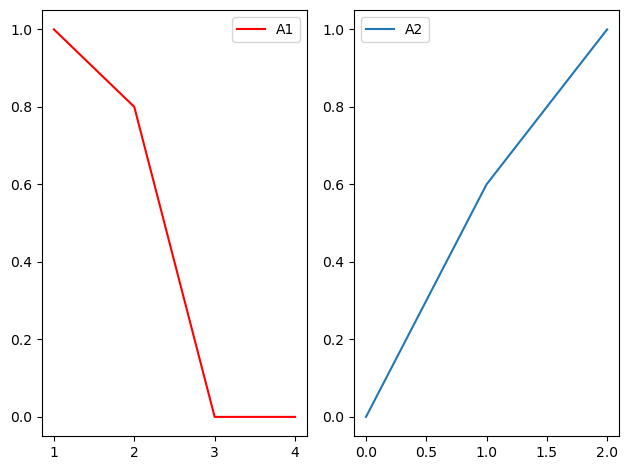

In [7]:
# Example 7.1 subsets
A1 = np.array([1, 0.8, 0, 0])
X1 = np.arange(1, len(A1)+1)

A2 = np.array([0, 0.6, 1])
X2 = np.arange(len(A2))

fig, ax = plt.subplots(1,2)

ax[0].plot(X1, A1, 'r',label='A1')
ax[1].plot(X2, A2,label='A2')
ax[0].legend()
ax[1].legend()

plt.tight_layout()

## Plot antecedents over their respective domains

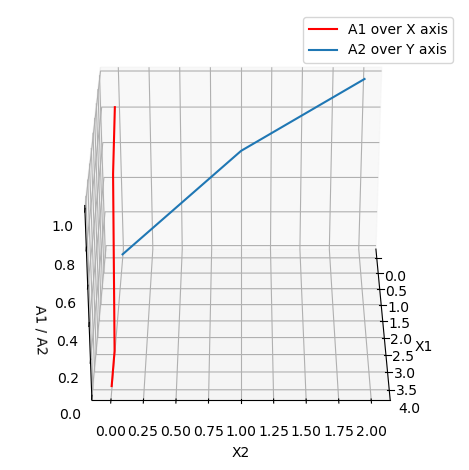

In [8]:
# Data
A1 = np.array([1, 0.8, 0, 0])
X1 = np.arange(1, len(A1)+1)

A2 = np.array([0, 0.6, 1])
X2 = np.arange(len(A2))

# Creating the 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plotting A1 over X axis
ax.plot(X1, A1, zs=0, zdir='y', label='A1 over X axis', color='r')

# Plotting A2 over Y axis
ax.plot(X2, A2, zs=0, zdir='x', label='A2 over Y axis')

ax.view_init(elev=30, azim=0)


# Adding labels and legend
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('A1 / A2')
ax.legend()

plt.tight_layout()
plt.show()


## Project them into the cross product space

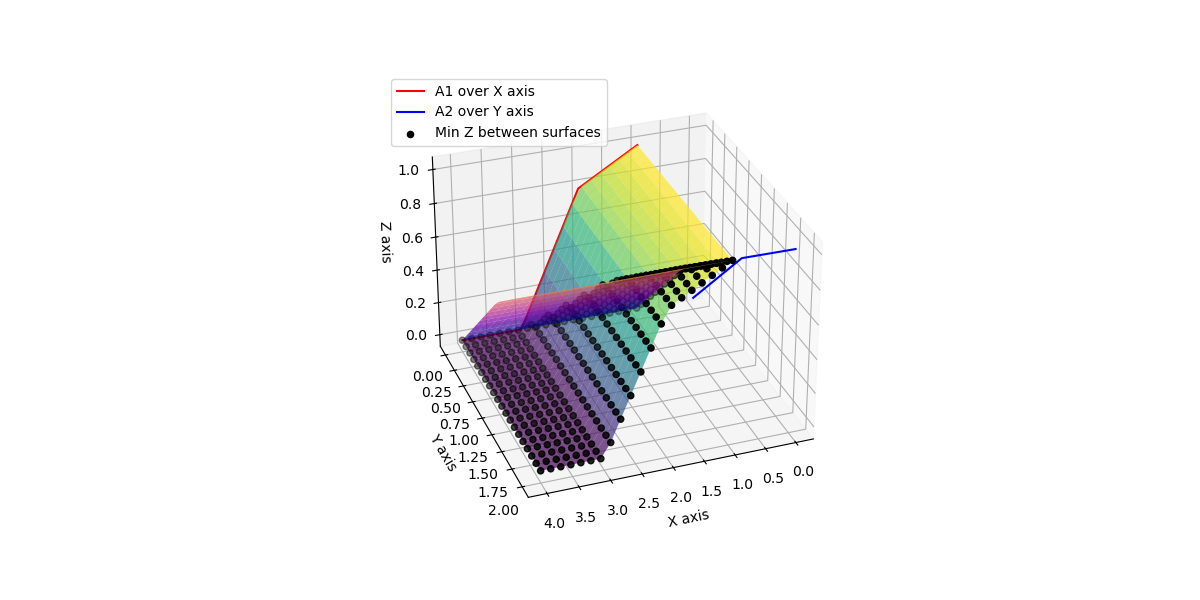

In [9]:
%matplotlib widget

# Data
A1 = np.array([1, 0.8, 0, 0])
X1 = np.arange(1, len(A1) + 1)

A2 = np.array([0, 0.6, 1])
X2 = np.arange(len(A2))

# Create grid
N = 20
x_values = np.linspace(np.min(X1), np.max(X1), N)
y_values = np.linspace(np.min(X2), np.max(X2), N)

X_grid, Y_grid = np.meshgrid(x_values, y_values)

# Interpolate Z values for both surfaces
Z1 = griddata(X1, A1, x_values, method='linear')
Z2 = griddata(X2, A2, y_values, method='linear')

# Create full Z grids for surface plots
Z1_grid = np.tile(Z1, (N, 1))
Z2_grid = np.tile(Z2, (N, 1)).T

# Calculate minimum Z values for each (X, Y)
Z_min_grid = np.minimum(Z1_grid, Z2_grid)

# Plotting
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')

# Plotting A1 over X axis
ax.plot(X1, A1, zs=0, zdir='y', label='A1 over X axis', color='r')

# Plotting A2 over Y axis
ax.plot(X2, A2, zs=0, zdir='x', label='A2 over Y axis', color='b')

# Set viewing angle
ax.view_init(elev=30, azim=70)

# Surface plot for A1
ax.plot_surface(X_grid, Y_grid, Z1_grid, cmap='viridis', alpha=0.7)

# Surface plot for A2
ax.plot_surface(X_grid, Y_grid, Z2_grid, cmap='plasma', alpha=0.7)

# Highlight the minimum Z values between the two surfaces
ax.scatter(X_grid, Y_grid, Z_min_grid, color='k', s=20, label='Min Z between surfaces')

# Set labels and legend
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
ax.legend()

# Show plot
plt.show()


## Plot the cylindrical closure

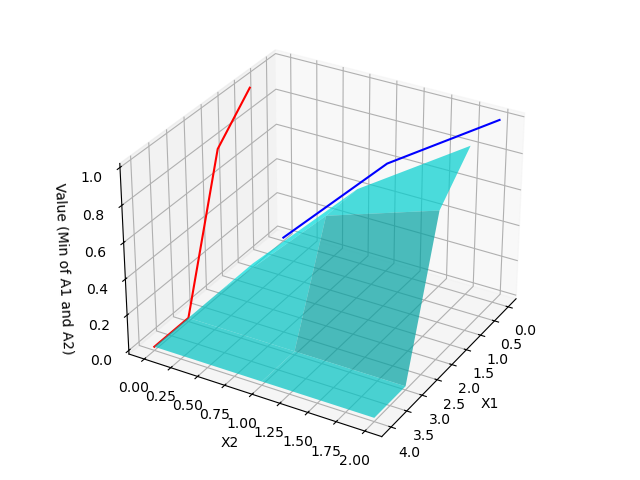

In [10]:

# Data
A1 = np.array([1, 0.8, 0, 0])
X1 = np.arange(1, len(A1) + 1)

A2 = np.array([0, 0.6, 1])
X2 = np.arange(len(A2))

# Creating the mesh grid for cross product space
X1_grid, X2_grid = np.meshgrid(X1, X2)

# Create the surface where the value is the minimum between A1 and A2
A1_expanded = np.tile(A1, (len(X2), 1))
A2_expanded = np.tile(A2.reshape(-1, 1), (1, len(X1)))
Z = np.minimum(A1_expanded, A2_expanded)

# Creating the 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plotting the surface
ax.plot_surface(X1_grid, X2_grid, Z, color='cyan', alpha=0.7, label='Min Surface')

# Plotting the original A1 and A2 lines for reference
ax.plot(X1, np.zeros_like(X1), A1, color='r', label='A1 over X axis')
ax.plot(np.zeros_like(X2), X2, A2, color='b', label='A2 over Y axis')

# Setting view angle
ax.view_init(elev=30, azim=30)

# Adding labels and legend
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Value (Min of A1 and A2)')

plt.tight_layout()
plt.show()


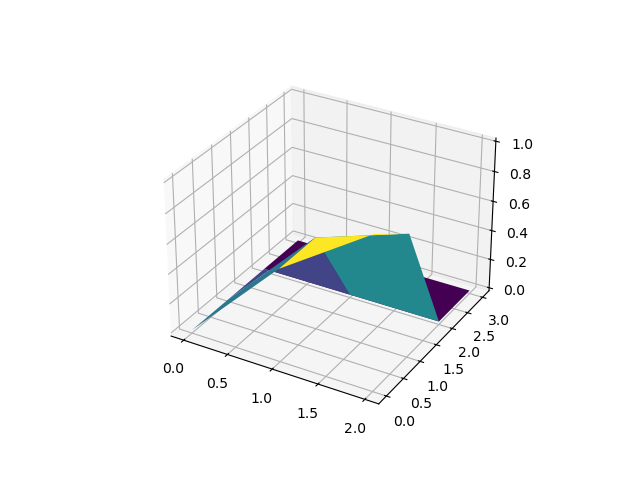

In [30]:
# U1 is A1 AND U2 is A2
D1 = cylindrical_closure(A1,A2)
D1

# plot
x = np.arange(D1.shape[1])
y = np.arange(D1.shape[0])
X,Y = np.meshgrid(x,y)

fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')

ax.plot_surface(X,Y,D1,cmap='viridis')
plt.show()

In [12]:
D1

array([[0. , 0.6, 1. ],
       [0. , 0.6, 0.8],
       [0. , 0. , 0. ],
       [0. , 0. , 0. ]])

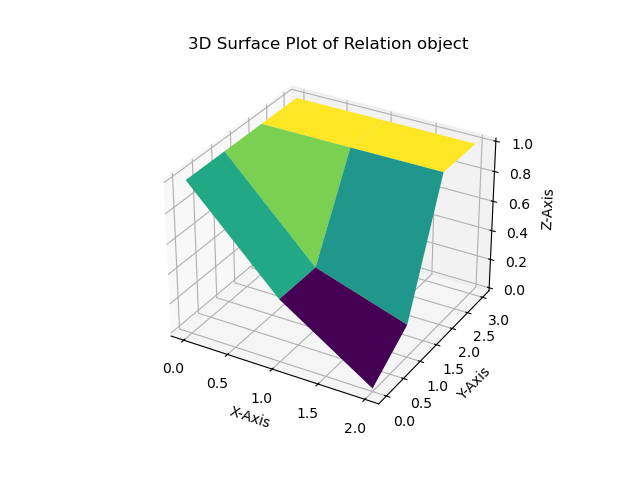

In [13]:
# IF U1 is A1 and U2 is A2 THEN V is B
Y = [0,0.5,1]
R1 = relation(D1,Y,implication_zadeh)
R1

# plot 
from mpl_toolkits.mplot3d import Axes3D
x = np.arange(R1.shape[2])
y = np.arange(R1.shape[1])

X,Y = np.meshgrid(x,y)
Z = R1[0]

# Create a figure and a 3D axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the 3D surface
ax.plot_surface(X, Y, Z, cmap='viridis')

# Customize the plot
ax.set_xlabel('X-Axis')
ax.set_ylabel('Y-Axis')
ax.set_zlabel('Z-Axis')
ax.set_title('3D Surface Plot of Relation object')

# Show the plot
plt.show()



In [14]:
# U1 is A1'=A1 and U2 is A2'=A2
A1_ = A1
A2_ = A2
Y_ = COI(R1,Y,A1,A2)
Y_



array([[0, 0, 0],
       [0, 0, 0],
       [1, 1, 1],
       [0, 0, 0]])

# 3 antecedent example

In [15]:
A1 = np.array([1, 0.8, 0, 0])
X1 = np.arange(1, len(A1)+1)

A2 = np.array([0, 0.6, 1])
X2 = np.arange(len(A2))

A3 = np.array([0, 0.5, 1, 0.5, 0])
X3 = np.arange(0, len(A3)+1)

In [16]:
# U1 IS A1 AND U2 IS A2 AND U3 IS A3
D2 = cylindrical_closure(A1,A2,A3)
D2


array([[[0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. ]],

       [[0. , 0. , 0. , 0. ],
        [0.5, 0.5, 0. , 0. ],
        [0.5, 0.5, 0. , 0. ]],

       [[0. , 0. , 0. , 0. ],
        [0.6, 0.6, 0. , 0. ],
        [1. , 0.8, 0. , 0. ]],

       [[0. , 0. , 0. , 0. ],
        [0.5, 0.5, 0. , 0. ],
        [0.5, 0.5, 0. , 0. ]],

       [[0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. ]]])

In [17]:

D2.shape

(5, 3, 4)

In [18]:
# IF U1 IS A1 AND U2 IS A2 AND U3 IS A3 THEN V IS B
Y = [0, 0.5, 1]
R2 = relation(D2,Y,implication_correlation_prod)
R2

array([[[[0.  , 0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  , 0.  ]],

        [[0.  , 0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  , 0.  ]],

        [[0.  , 0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  , 0.  ]],

        [[0.  , 0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  , 0.  ]],

        [[0.  , 0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  , 0.  ]]],


       [[[0.  , 0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  , 0.  ]],

        [[0.  , 0.  , 0.  , 0.  ],
         [0.25, 0.25, 0.  , 0.  ],
         [0.25, 0.25, 0.  , 0.  ]],

        [[0.  , 0.  , 0.  , 0.  ],
         [0.3 , 0.3 , 0.  , 0.  ],
         [0.5 , 0.4 , 0.  , 0.  ]],

        [[0.  , 0.  , 0.  , 0.  ],
         [0.25, 0.25, 0.  , 0.  ],
         [0.25, 0.25, 0.  , 0.  ]],

        [[0.  , 0.  , 0.  , 0.  ],


In [19]:
R2.shape

(3, 5, 3, 4)

In [20]:
A1_ = A1
A2_ = A2
A3_ = A3


Y_ = COI(R2, Y, A1, A2, A3)
Y_
                

array([0. , 0.5, 1. ])

# Example with aggregation

C:\Users\Zayan\AppData\Local\Temp\ipykernel_13512\3425820237.py:21: RuntimeWarning: divide by zero encountered in divide
  np.where((X >= a) & (X < b), (X - a) / (b - a),
C:\Users\Zayan\AppData\Local\Temp\ipykernel_13512\3425820237.py:21: RuntimeWarning: invalid value encountered in divide
  np.where((X >= a) & (X < b), (X - a) / (b - a),
C:\Users\Zayan\AppData\Local\Temp\ipykernel_13512\3425820237.py:23: RuntimeWarning: divide by zero encountered in divide
  np.where((X > c) & (X <= d), (d - X) / (d - c), 0.0))))
C:\Users\Zayan\AppData\Local\Temp\ipykernel_13512\3425820237.py:23: RuntimeWarning: invalid value encountered in divide
  np.where((X > c) & (X <= d), (d - X) / (d - c), 0.0))))


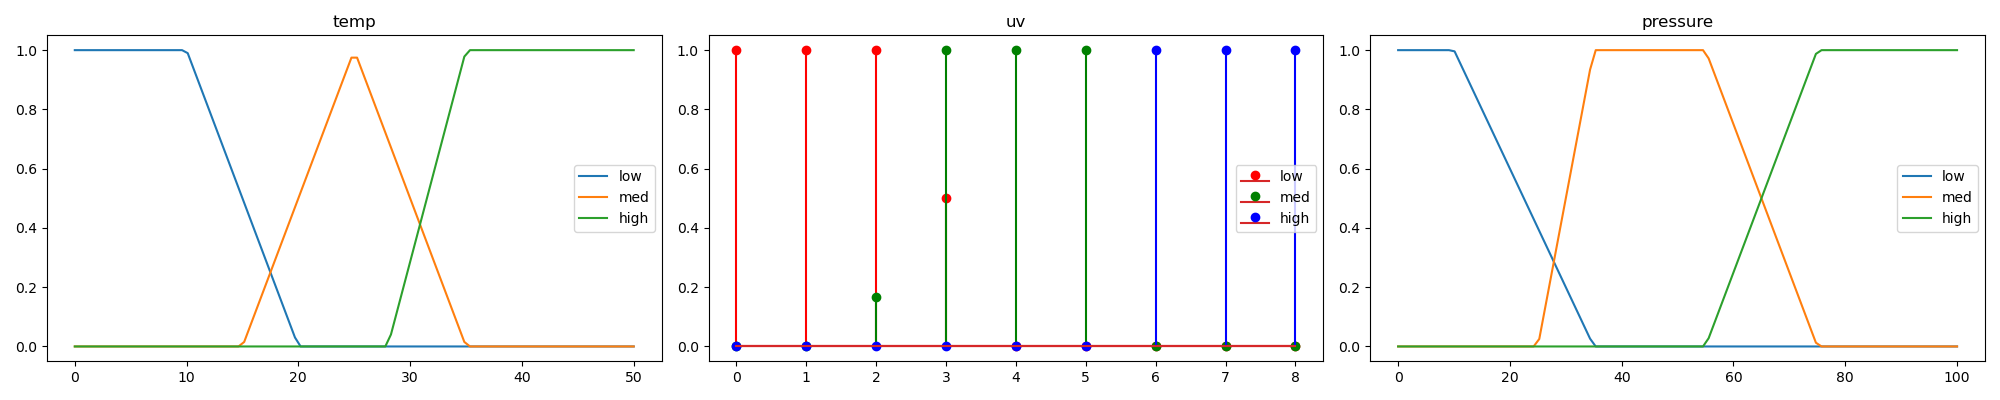

In [21]:
input_domains = ['temp','uv','air_pressure']
output_domains = ['rain','sunshine','wind']

# subsets
x_temp = np.linspace(0,50,100) 
x_uv = np.arange(0,9) # https://www.epa.gov/enviro/uv-index-description
x_pressure = np.linspace(0,100,100)

temp_low = trapezoid(x_temp,0,0,10,20)
temp_med = trimf(x_temp, 15,25,35)
temp_high = trapezoid(x_temp, 28,35,50,50)

uv_low = trapezoid(x_uv,0,0,2,4)
uv_med = trapezoid(x_uv,1.8,3,5.5,5.7)
uv_high = trapezoid(x_uv, 5.5,6,8,8)

pressure_low = trapezoid(x_pressure, 0,0,10,35)
pressure_med = trapezoid(x_pressure, 25,35,55,75)
pressure_high = trapezoid(x_pressure, 55,75,100,100)

fig, ax = plt.subplots(1,3, figsize=(20,4))

ax[0].plot(x_temp,temp_low,label='low')
ax[0].plot(x_temp,temp_med,label='med')
ax[0].plot(x_temp,temp_high,label='high')
ax[0].set_title('temp')
ax[0].legend()

ax[1].stem(x_uv,uv_low,'r',label='low')
ax[1].stem(x_uv,uv_med,'g',label='med')
ax[1].stem(x_uv,uv_high,'b',label='high')
ax[1].set_title('uv')
ax[1].legend()

ax[2].plot(x_pressure,pressure_low,label='low')
ax[2].plot(x_pressure,pressure_med,label='med')
ax[2].plot(x_pressure,pressure_high,label='high')
ax[2].set_title('pressure')
ax[2].legend()

plt.tight_layout()

C:\Users\Zayan\AppData\Local\Temp\ipykernel_13512\3425820237.py:21: RuntimeWarning: divide by zero encountered in divide
  np.where((X >= a) & (X < b), (X - a) / (b - a),
C:\Users\Zayan\AppData\Local\Temp\ipykernel_13512\3425820237.py:21: RuntimeWarning: invalid value encountered in divide
  np.where((X >= a) & (X < b), (X - a) / (b - a),
C:\Users\Zayan\AppData\Local\Temp\ipykernel_13512\3425820237.py:23: RuntimeWarning: divide by zero encountered in divide
  np.where((X > c) & (X <= d), (d - X) / (d - c), 0.0))))
C:\Users\Zayan\AppData\Local\Temp\ipykernel_13512\3425820237.py:23: RuntimeWarning: invalid value encountered in divide
  np.where((X > c) & (X <= d), (d - X) / (d - c), 0.0))))


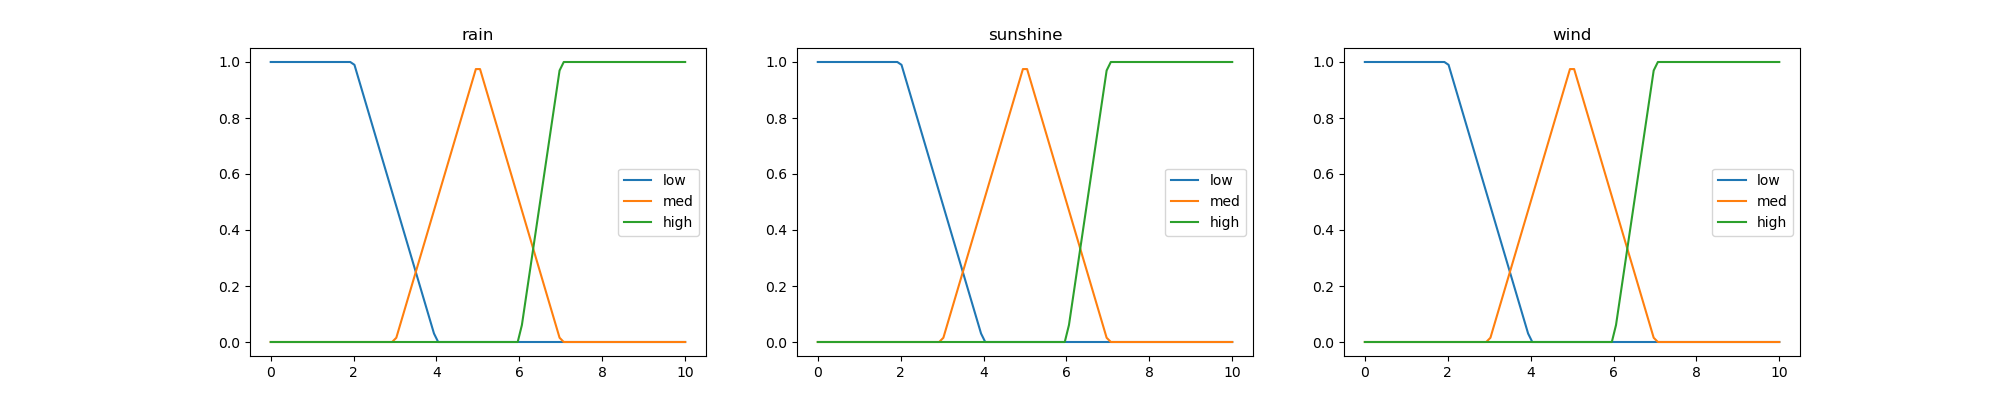

In [22]:
# output subsets
x_rain = np.linspace(0,10,100)
x_sunshine = x_rain
x_wind = x_rain

rain_low = trapezoid(x_rain,0,0,2,4)
rain_med = trimf(x_rain, 3,5,7)
rain_high = trapezoid(x_rain, 6,7,10,10)

sunshine_low, sunshine_med, sunshine_high = rain_low.copy(), rain_med.copy(), rain_high.copy()
wind_low, wind_med, wind_high = rain_low.copy(), rain_med.copy(), rain_high.copy()

fig, ax = plt.subplots(1,3, figsize=(20,4))

ax[0].plot(x_rain,rain_low,label='low')
ax[0].plot(x_rain,rain_med,label='med')
ax[0].plot(x_rain,rain_high,label='high')
ax[0].set_title('rain')
ax[0].legend()

ax[1].plot(x_sunshine,sunshine_low,label='low')
ax[1].plot(x_sunshine,sunshine_med,label='med')
ax[1].plot(x_sunshine,sunshine_high,label='high')
ax[1].set_title('sunshine')
ax[1].legend()

ax[2].plot(x_wind,wind_low,label='low')
ax[2].plot(x_wind,wind_med,label='med')
ax[2].plot(x_wind,wind_high,label='high')
ax[2].set_title('wind')
ax[2].legend()


DATASTRUCTURE FOR RULE: [DICTIONARY1, DICTIONARY2] where DICTIONARY1 = ANTECEDENTS, DICTIONARY2 = CONSEQUENT

In [23]:
# rules

# DATASTRUCTURE FOR RULE: [DICTIONARY1, DICTIONARY2] where DICTIONARY1 = ANTECEDENTS, DICTIONARY2 = CONSEQUENT

# rain_rule1 = [ {'temp':temp_low,'uv':uv_low,'pressure':pressure_high}, rain_high ] # IF TEMP IS LOW AND UV IS LOW AND PRESSURE IS HIGH THEN RAIN IS HIGH
# rain_rule2 = [ {'uv':uv_low}, rain_low ] # IF UV IS LOW THEN RAIN IS LOW
# rain_rule3 = [ {'uv':uv_med, 'pressure':pressure_med}, rain_med ] # IF UV IS MED AND PRESSURE IS MED THEN RAIN IS MED
# rain_rule4 = [ {'uv':uv_high}, rain_low]
# rain_rule5 = [ {'temp':temp_high}, rain_med]
# rain_rule6 = [ {'temp':temp_med}, rain_med]
# rain_rule7 = [ {'temp':temp_med, 'pressure':pressure_high},rain_high]
# rain_rule8 = [ {'pressure':pressure_low},rain_low]

wind_rule1 = [ {'temp':temp_low}, wind_med]
wind_rule2 = [ {'temp':temp_med}, wind_med]
wind_rule3 = [ {'pressure':pressure_low}, wind_high]
wind_rule4 = [ {'pressure':pressure_high}, wind_low]
wind_rule5 = [ {'pressure':pressure_med},wind_med]
wind_rule4 = [ {'uv':uv_high}, wind_low]
wind_rule5 = [ { 'temp':temp_high},wind_low]

wind_rules = [wind_rule1, wind_rule2, wind_rule3, wind_rule4, wind_rule5]

sun_rule1 = [ {'uv':uv_high}, sunshine_high]
sun_rule2 = [ {'temp':temp_high}, sunshine_high]
sun_rule3 = [ { 'uv':uv_low}, sunshine_low]
sun_rule4 = [ {'uv':uv_med, 'temp':temp_med}, sunshine_med]
sun_rule5 = [ {'pressure':pressure_high, 'temp':temp_low}, sunshine_med]
sun_rule6 = [ {'pressure':pressure_low}, sunshine_low]
sun_rule7 = [ {'pressure':pressure_med}, sunshine_med]

sun_rules = [sun_rule1, sun_rule2, sun_rule3, sun_rule4, sun_rule5, sun_rule6,sun_rule7]


rain_rule1 = [ {'pressure':pressure_high},rain_low]
rain_rule2 = [ {'uv':uv_low}, rain_med]
rain_rule3 = [ {'uv':uv_high},rain_low]
rain_rule4 = [ {'pressure':pressure_low},rain_high]
rain_rule5 = [ {'temp':temp_low},rain_med]

rain_rules = [rain_rule1,rain_rule2,rain_rule3, rain_rule4, rain_rule5]

rule_bases = [rain_rules,sun_rules,wind_rules]



In [24]:
new_data = {'uv':uv_low, 'temp':temp_low, 'pressure':pressure_low}
# new_data = {'uv':uv_high, 'temp':temp_high, 'pressure':pressure_low}

In [25]:
def FIS_rule_base(rule_base_name, new_data, implication_op):

    if rule_base_name == 'rain':
        rule_base = rain_rules
        x = x_rain
    elif rule_base_name == 'sun':
        rule_base = sun_rules
        x = x_sunshine
    elif rule_base_name == 'wind':
        rule_base = wind_rules
        x = x_wind
    else:
        raise Exception("rule base not provided")
    
    all_B_ = []
    for rule in rule_base:
        antecedents_n = len(rule[0])
        
        if antecedents_n == 1:

            A_name = list(rule[0].keys())[0] # get the name of the domain
            A = rule[0][A_name]
            B = rule[1]
            A_ = new_data[A_name] # get A'

            R = relation_1_ant(A, B, implication_op)
            B_ = COI_1_ant(A_,B,R)
            
        else:
            # get names of antecedents in rule
            A_names = list(rule[0].keys())

            # initialize As and A's
            all_A = [None,None,None]
            all_A_ = [None,None,None]

            # get As and A's
            for i in range(len(A_names)):
                all_A[i] = rule[0][A_names[i]]
                all_A_[i] = new_data[A_names[i]]
            
            B = rule[1]
        
            D = cylindrical_closure(all_A[0],all_A[1],all_A[2])
            R = relation(D,B,implication_op)
            B_ = COI(R,B,all_A_[0],all_A_[1],all_A_[2])
        
        all_B_.append(B_)

    fig, ax = plt.subplots()

    for i in range(len(all_B_)):
        ax.plot(x, all_B_[i])

        
    return all_B_

def aggregate(all_rule_outputs,agg_method):

    if agg_method == 'sum':
        aggregated_output = all_rule_outputs[0]

        for rule_output in all_rule_outputs[1:]:
            aggregated_output = aggregated_output + rule_output

        return aggregated_output

    elif agg_method == 'max':
        aggregated_output = all_rule_outputs[0]

        for rule_output in all_rule_outputs[1:]:
            aggregated_output = np.fmax(aggregated_output,rule_output)
        
        return aggregated_output

# function to get membership value of datum in a subset
def interp_mem_val(subset_arr, X, datum):
    '''Get membership of data in subset'''
        
    # convert universe of discourse (list) to a numpy array
    X_array = np.asarray(X)
    # find the nearest two points
    l = X_array[X_array <= datum][-1] # grab value immediately below data
    u = X_array[X_array >= datum][0] # grab value immediately above data

    idl = np.nonzero(X_array == l)[0][0] # grab index of value immediately below data
    idu = np.nonzero(X_array == u)[0][0] # grab index of value immediately above data

    if idl==idu:
        id = idl
        mem_val = subset_arr[id]
        return round(mem_val,5)
    
    lower_mv = subset_arr[idl]
    upper_mv = subset_arr[idu]

    slope = (upper_mv - lower_mv) / float(u - l)
    mem_val = slope * (datum - l) + lower_mv

    return round(mem_val,5)

def centroid():
    pass
        

5
7.10744323745366


Text(0.5, 1.0, 'aggregated output (max)')

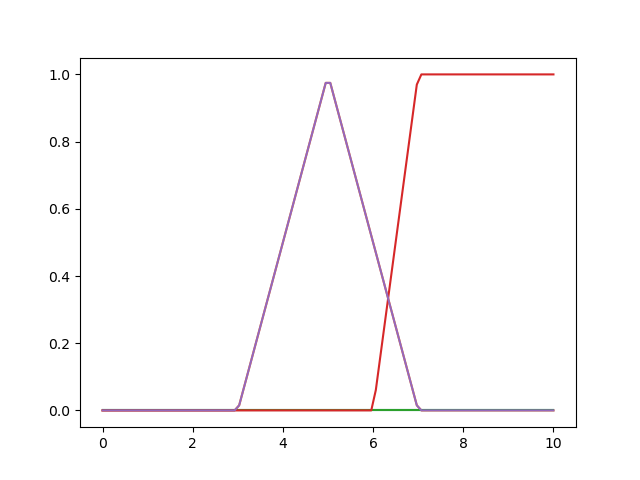

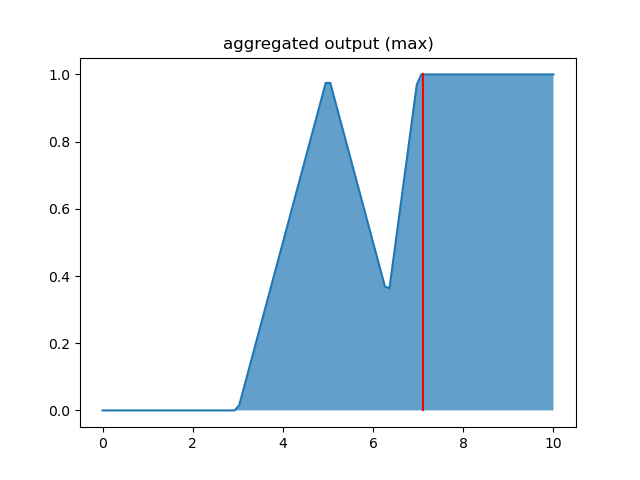

In [26]:
outputs = FIS_rule_base('rain',new_data,implication_correlation_min)
aggregated = aggregate(outputs,'max')
method = 'max'
print(len(outputs))

# defuzzify
centroid = np.average(x_rain,weights=aggregated)
# centroid = fuzz.defuzz(x_rain,aggregated,'centroid')
print(centroid)

centroid_mf = interp_mem_val(aggregated,x_rain,centroid)

plt.figure()
plt.plot(x_rain,aggregated)
plt.plot([centroid,centroid],[0, centroid_mf],'r')
plt.fill_between(x_rain,aggregated,alpha=0.7)
plt.title(f'aggregated output ({method})')

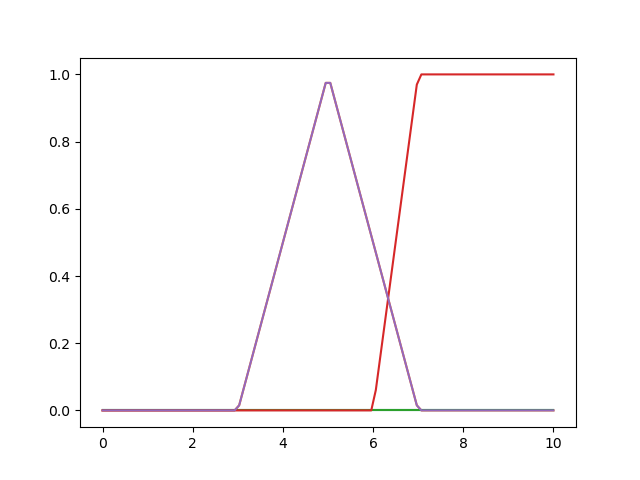

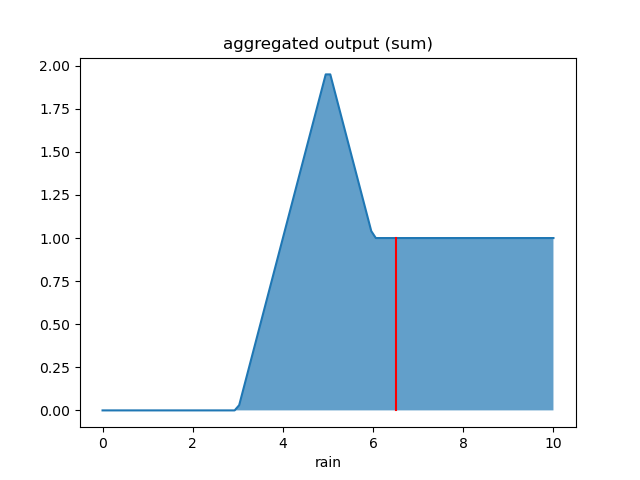

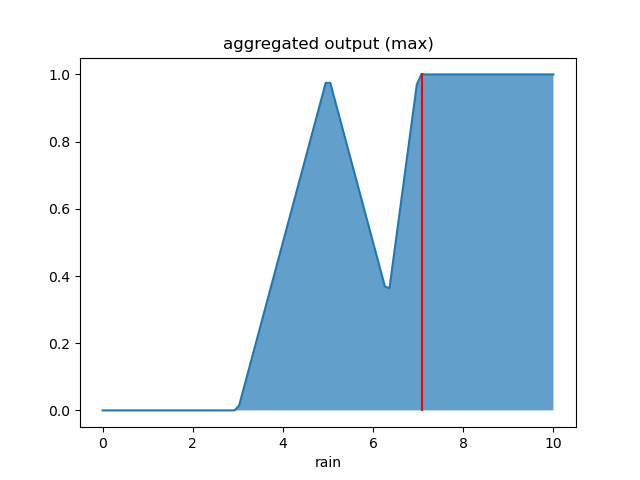

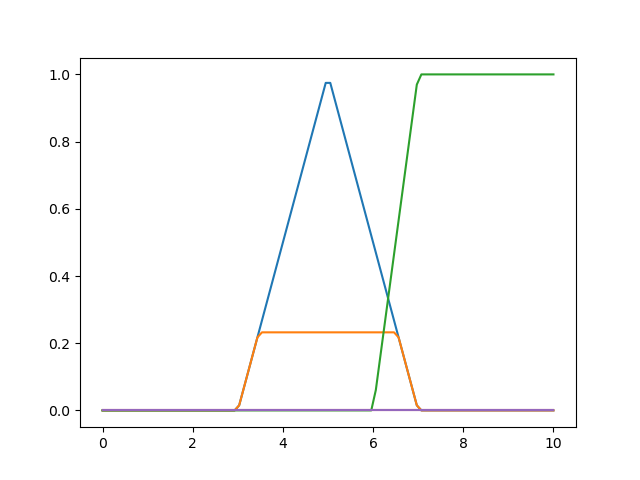

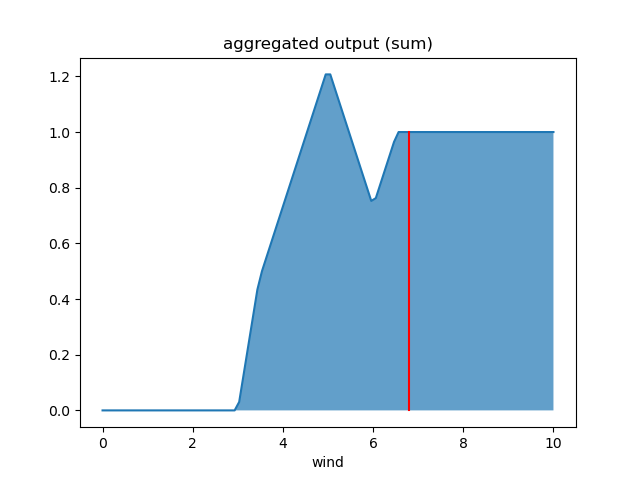

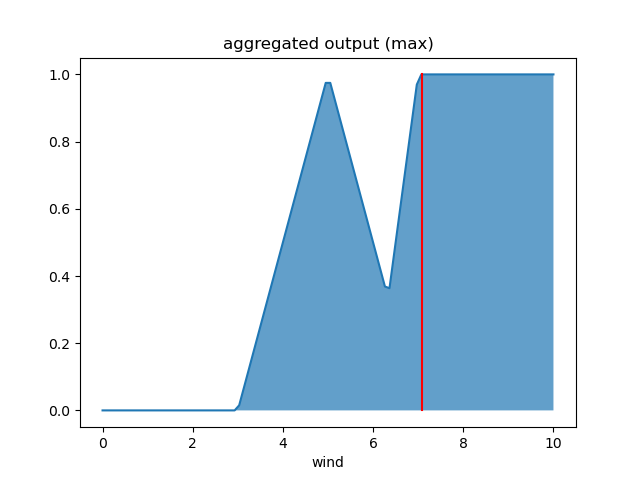

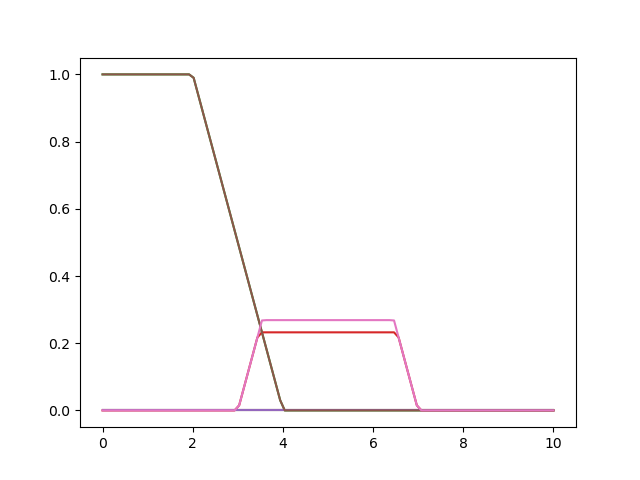

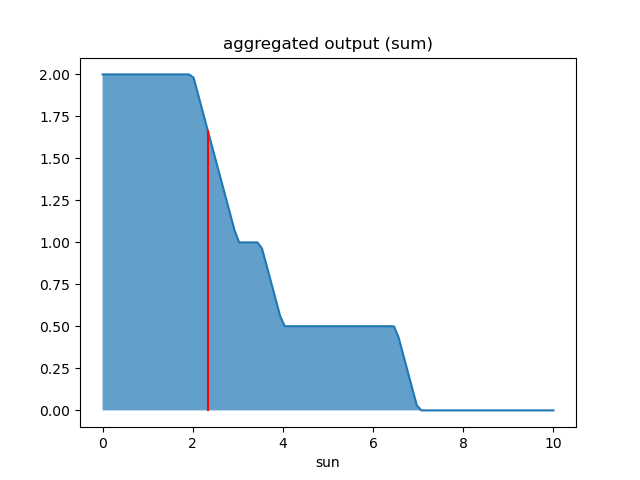

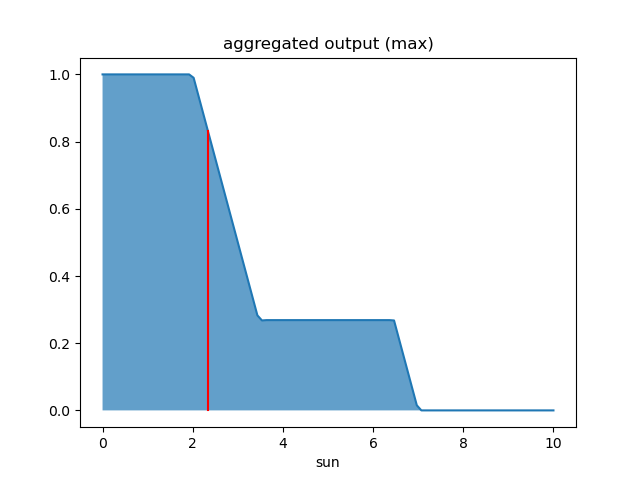

In [27]:
rule_bases = ['rain','wind','sun']
agg_methods = ['sum','max']
outputs = []
aggregated_outputs = []

for rb in rule_bases:

    # get Bi's
    output = FIS_rule_base(rb,new_data,implication_correlation_min)

    # aggregate
    for method in agg_methods:
        aggregated = aggregate(output,method)

        # defuzzify
        centroid = np.average(x_rain, weights=aggregated)
        centroid = fuzz.defuzz(x_rain,aggregated,'centroid')

        centroid_mf = interp_mem_val(aggregated,x_rain,centroid)

        plt.figure()
        plt.plot(x_rain,aggregated)
        plt.xlabel(rb)
        plt.plot([centroid,centroid],[0, centroid_mf],'r')
        plt.fill_between(x_rain,aggregated,alpha=0.7)
        plt.title(f'aggregated output ({method})')

        

